**BEFORE YOU FORK, PLEASE SUPPORT AND UPVOTE**

# What is your model looking at?
## Model Analysis - GradCAM with fastai (APTOS)

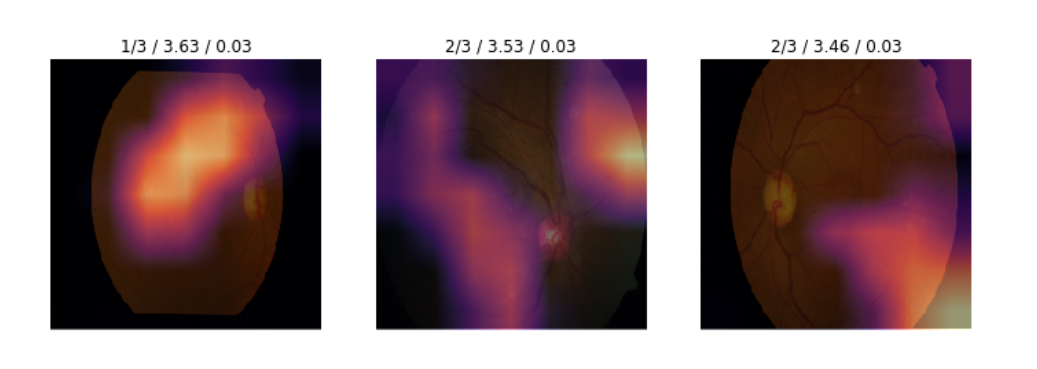

In this kernel, we will use a technique known as Gradient-weighted Class Activation Mapping, or GradCAM, to analyze the predictions of our model, and understand what parts of the image our CNNs are looking at. GradCAM uses the activations of the network to produce localization heatmaps.

I will use fastai, because GradCAM is already implemented (with a caveat), and since my previous kernels were also using fastai.

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai import *
from fastai.vision import *
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Making pretrained weights work without needing to find the default filename
if not os.path.exists('/tmp/.cache/torch/checkpoints/'):
        os.makedirs('/tmp/.cache/torch/checkpoints/')
!cp '../input/resnet50/resnet50.pth' '/tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth'

In [ ]:
import os
os.listdir('../input')

In [ ]:
print('Make sure cudnn is enabled:', torch.backends.cudnn.enabled)

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 999
seed_everything(SEED)

## Reading data and Basic EDA

Here I am going to open the dataset with pandas, check distribution of labels.

In [ ]:
base_image_dir = os.path.join('..', 'input/aptos2019-blindness-detection/')
train_dir = os.path.join(base_image_dir,'train_images/')
df = pd.read_csv(os.path.join(base_image_dir, 'train.csv'))
df['path'] = df['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
df = df.drop(columns=['id_code'])
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
df.head(10)

In [ ]:
len_df = len(df)
print(f"There are {len_df} images")

The dataset is highly imbalanced, with many samples for level 0, and very little for the rest of the levels. When we use GradCAM, let's see what the heatmaps are for the classes with lower counts. 

In [ ]:
df['diagnosis'].hist(figsize = (10, 5))

In [ ]:
bs = 64 #smaller batch size is better for training, but may take longer
sz=224

In [ ]:
tfms = get_transforms(do_flip=True,flip_vert=True,max_rotate=360,max_warp=0,max_zoom=1.1,max_lighting=0.1,p_lighting=0.5)
src = (ImageList.from_df(df=df,path='./',cols='path') #get dataset from dataset
        .split_by_rand_pct(0.2) #Splitting the dataset
        .label_from_df(cols='diagnosis') #obtain labels from the level column
      )
data= (src.transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') #Data augmentation
        .databunch(bs=bs,num_workers=4) #DataBunch
        .normalize(imagenet_stats) #Normalize     
       )

In [ ]:
data.show_batch(rows=3, figsize=(7,6))

## Training (Transfer learning)

In [ ]:
from sklearn.metrics import cohen_kappa_score
def quadratic_kappa(y_hat, y):
    return torch.tensor(cohen_kappa_score(y_hat.argmax(dim=-1), y, weights='quadratic'),device='cuda:0')

**Training:**

We use transfer learning, where we retrain the last layers of a pretrained neural network. I use the ResNet50 architecture trained on the ImageNet dataset, which has been commonly used for pre-training applications in computer vision. Fastai makes it quite simple to create a model and train:

In [ ]:
learn = cnn_learner(data, base_arch=models.resnet50, metrics = [quadratic_kappa])

In [ ]:
learn.fit_one_cycle(4,max_lr = 1e-2)

In [ ]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(6, max_lr=slice(1e-6,1e-3))

In [ ]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

Let's evaluate our model:

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

## GradCAM

** Theory and objective of GradCAM **

The idea behind GradCAM is:
* The activations, which are outputted at the end of the convolutional part of the model (before being passed to global pooling and the class scores are outputted), will contain useful information regarding the importance of features in the image for classification.
* While there may be many different features important in the model, the gradient of the predicted class with respect to these activations will contain information about what features lead to the final prediction of the class.

We multiply the activation map with the gradient map to get the final GradCAM localization map.

Let's first get a single image and pu[](http://)t it into a minibatch. We put it into a minibatch as that is what our model expects.

In [ ]:
idx = 1
im,cl = learn.data.dl(DatasetType.Valid).dataset[idx]
cl = int(cl)
im.show(title=f"pred. class: {interp.pred_class[idx]}, actual class: {learn.data.classes[cl]}")

In [ ]:
xb,_ = data.one_item(im) #put into a minibatch of batch size = 1
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

Now let's access the model of the `Learner` object.

In [ ]:
m = learn.model.eval()

PyTorch and fastai have nicely separated the convolutional parts of the model from the fully connected layers. There are two elements in this "Sequential container". The first element are the convolutional layers, while the second element are the fully connected layers. We want the output of the convolutional layers, i.e. the output of `m[0]`. 

In [ ]:
type(m)

In [ ]:
len(m)

Now we will have to access the output and gradients of `m[0]`. To do so, we use [hooks](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks) in PyTorch. 
* These hooks are somewhat abstracted by the fastai library. Instead, the fastai library has a function `hook_output` that will create a hook and store the activations when a backpropagation of the model is done.

In [ ]:
from fastai.callbacks.hooks import *

In [ ]:
def hooked_backward(cat=cl):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g
hook_a,hook_g = hooked_backward()

Now, whenever this function above is called, it will return `hook_a`, which stores the output of the convolutional layers, and `hook_g` which stores the gradients with respect to the predicted class (`grad=True` and `preds[0,int(cat)].backward()`). Here is how we can view these values:

In [ ]:
acts  = hook_a.stored[0].cpu() #activation maps
acts.shape

In [ ]:
grad = hook_g.stored[0][0].cpu() #gradients
grad.shape

2048 are the number of channels, and 7 is the height and width of the feature maps. So we have 2048 feature maps with sizes 7x7.

Now we average pool the gradients, which gives us "importance weights" for each of the 2048 activation maps. We then multiply the feature maps by their importance weights and sum and finally pass into ReLU. This is our GradCAM map.

In [ ]:
grad_chan = grad.mean(1).mean(1) # importance weights
grad_chan.shape

In [ ]:
mult = F.relu(((acts*grad_chan[...,None,None])).sum(0)) # GradCAM map
mult.shape

In [ ]:
#Utility function to display heatmap:
def show_heatmap(hm):
    _,ax = plt.subplots()
    sz = list(xb_im.shape[-2:])
    xb_im.show(ax,title=f"pred. class: {interp.pred_class[idx]}, actual class: {learn.data.classes[cl]}")
    ax.imshow(hm, alpha=0.6, extent=(0,*sz[::-1],0),
              interpolation='bilinear', cmap='magma')
    return _,ax

In [ ]:
show_heatmap(mult)

Let's put this into one large function that will take in an index for an image in the dataset, and return the GradCAM map:

In [ ]:
def GradCAM(idx:int,interp:ClassificationInterpretation, image = True):
    m = interp.learn.model.eval()
    im,cl = interp.learn.data.dl(DatasetType.Valid).dataset[idx]
    cl = int(cl)
    xb,_ = interp.data.one_item(im) #put into a minibatch of batch size = 1
    xb_im = Image(interp.data.denorm(xb)[0])
    xb = xb.cuda()
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cl)].backward() 
    acts  = hook_a.stored[0].cpu() #activation maps
    grad = hook_g.stored[0][0].cpu()
    grad_chan = grad.mean(1).mean(1)
    mult = ((acts*grad_chan[...,None,None])).sum(0) #F.relu(((acts*grad_chan[...,None,None])).sum(0))
    if image:
        _,ax = plt.subplots()
        sz = list(xb_im.shape[-2:])
        xb_im.show(ax,title=f"pred. class: {interp.pred_class[idx]}, actual class: {learn.data.classes[cl]}")
        ax.imshow(mult, alpha=0.4, extent=(0,*sz[::-1],0),
              interpolation='bilinear', cmap='magma')
    return mult

In [ ]:
_ = GradCAM(np.random.randint(len(learn.data.valid_ds)),interp)

What are potential uses for GradCAM? GradCAM is meant to provide some form of interpretability to these neural network models. In doing so, we can also better evaluate failure modes and identify biases. Which such information, we can develop better models.

Along those lines, `fastai` already has GradCAM implemented, but it is only implemented when displaying images that the model was most wrong about. This will help us better understand where our model is going wrong. To do this we use the `interp.plot_top_losses()` function. The implementation is identical to the my code above (the above code was written based on the fastai source code and fastai course).

In [ ]:
return_fig = interp.plot_top_losses(6,heatmap=True,return_fig = True)

I hope this kernel helps you utilize GradCAM in your own models and help you train better models. If you found this kernel useful, please be sure to upvote!

**Future work:**
* More conclusions regarding GradCAM heatmaps
* Guided backprop
* Analyze kernels in middle layers